In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, json, random, math, os, sys

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Conv1D, Dense, Dropout, SpatialDropout1D, LayerNormalization, Activation, Add, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
file_name = ".SEED.txt"
with open(file_name, "r") as file:
    content = file.read().strip()  # Read and remove any extra whitespace/newlines
    number = int(content)  # Use float() to support decimal; use int() if it's always an integer

print("Seed:", number)
print("Type:", type(number))

Seed: 271828183
Type: <class 'int'>


In [3]:
# ---------------- User knobs ----------------
CSV_PATH = "ALL_MERGED.csv"  # <--- set your CSV path
DATE_COL = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude TARGET from X

TEST_SIZE   = 0.20
VAL_SIZE    = 0.10
RANDOM_SEED = number
MAX_EPOCHS  = 100
VERBOSE_TRAIN = 1

# Random search settings
N_TRIALS   = 50              # bump up (e.g., 40–60) for deeper search
PATIENCE   = 10
WEIGHTS_BEST = "Model Weights/rs_tcn_best.weights.h5"
MODEL_BEST   = "Model Checkpoints/tcn_rs_checkpoint.keras"

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

271828183


In [4]:
# ---------------- Load & prep data ----------------
df = pd.read_csv(CSV_PATH)

required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


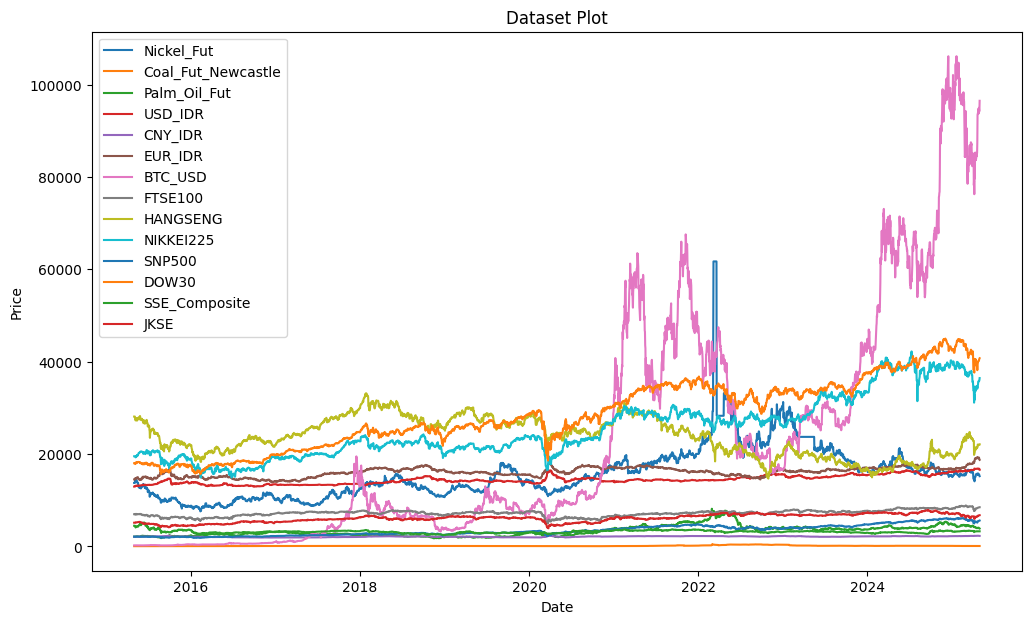

In [5]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [6]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [7]:
# ---------------- Split ----------------
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [8]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]
feature_cols

['Nickel_Fut',
 'Coal_Fut_Newcastle',
 'Palm_Oil_Fut',
 'USD_IDR',
 'CNY_IDR',
 'EUR_IDR',
 'BTC_USD',
 'FTSE100',
 'HANGSENG',
 'NIKKEI225',
 'SNP500',
 'DOW30',
 'SSE_Composite',
 'JKSE']

In [9]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [10]:
# ---------------- Utilities ----------------
def make_windows(X_df, y_df, lookback: int):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])    # predict current step (t)
        idx_list.append(idx[i])
    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

def tcn_block(x, filters, kernel_size, dilation_rate, drop_rate, use_ln, l2_reg):
    """A single residual TCN block with two causal convs + (optional) LN + SpatialDropout + residual add."""
    reg = regularizers.l2(l2_reg) if l2_reg > 0 else None

    y = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate,
               kernel_regularizer=reg)(x)
    if use_ln: y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = SpatialDropout1D(drop_rate)(y)

    y = Conv1D(filters, kernel_size, padding="causal", dilation_rate=dilation_rate,
               kernel_regularizer=reg)(y)
    if use_ln: y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = SpatialDropout1D(drop_rate)(y)

    # 1x1 projection if channels differ
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding="same", kernel_regularizer=reg)(x)

    out = Add()([x, y])
    return out

def build_tcn(input_shape, params):
    inp = Input(shape=input_shape)
    x = inp

    # apply num_stacks * dilation_schedule
    for _ in range(params["num_stacks"]):
        for d in params["base_dilations"]:
            x = tcn_block(
                x,
                filters=params["filters"],
                kernel_size=params["kernel_size"],
                dilation_rate=d,
                drop_rate=params["dropout"],
                use_ln=True,       # always True for Optuna
                l2_reg=0.0         # always 0 for Optuna
            )

    # compress channel then take last step
    x = Conv1D(1, 1, padding="same")(x)
    x = Lambda(lambda t: t[:, -1, :])(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)

    # Always Adam, like Optuna
    opt = Adam(learning_rate=params["lr"])
    model.compile(optimizer=opt, loss="mse")

    return model


def sample_params():
    params = {
        "lookback": random.choice([30, 45, 60, 90]),

        "filters": random.choice([32, 64, 96, 128]),
        "kernel_size": random.choice([3, 5, 7]),
        "dropout": np.random.uniform(0.0, 0.5),

        "num_stacks": random.choice([1, 2]),
        "base_dilations": random.choice([
            [1, 2, 4],
            [1, 2, 4, 8]
        ]),

        "lr": 10 ** np.random.uniform(-4, math.log10(5e-3)),
        "batch_size": random.choice([32, 64, 128]),
        "epochs": random.choice([30, 40, 50, 60, 70, 80, 90, 100]),
        "patience": random.choice([5, 6, 7, 8, 9, 10]),

        "optimizer": "adam",
        "use_layernorm": True,
        "l2_reg": 0.0
    }
    return params


def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [11]:
# ---------------- Random Search Loop ----------------
best = {"val_loss": np.inf, "params": None}

print("\n=== Random Search (TCN) begins ===")
hpo_start = time.time()  # HPO timer starts
for t in range(1, N_TRIALS + 1):
    params = sample_params()

    # Window using this trial's lookback
    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, params["lookback"])
    X_vl, y_vl, _ = make_windows(X_val_s,   y_val_s,   params["lookback"])

    model = build_tcn((params["lookback"], len(feature_cols)), params)

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ]

    start = time.time()
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_vl, y_vl),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=callbacks,
        verbose=0
    )
    dur = time.time() - start

    val_loss = float(min(hist.history["val_loss"]))
    print(f"[Trial {t:02d}] lb={params['lookback']}, stacks={params['num_stacks']}, "
          f"dils={params['base_dilations']}, filters={params['filters']}, k={params['kernel_size']}, "
          f"drop={params['dropout']}, LN={params['use_layernorm']}, opt={params['optimizer']}, "
          f"lr={params['lr']}, bs={params['batch_size']}, l2={params['l2_reg']}  => val_loss={val_loss:.6f} ({dur:.1f}s)")

    if val_loss < best["val_loss"]:
        best = {"val_loss": val_loss, "params": params}
        model.save_weights(WEIGHTS_BEST)
hpo_end = time.time()  # HPO timer ends
hpo_time_s = float(hpo_end - hpo_start)
hpo_trials = N_TRIALS

print("\nBest val_loss:", best["val_loss"])
print("Best params:\n", json.dumps(best["params"], indent=2))


=== Random Search (TCN) begins ===

[Trial 01] lb=90, stacks=1, dils=[1, 2, 4, 8], filters=32, k=3, drop=0.28610823087968634, LN=True, opt=adam, lr=0.0006023757744019968, bs=32, l2=0.0  => val_loss=0.057764 (25.3s)
[Trial 02] lb=60, stacks=1, dils=[1, 2, 4], filters=96, k=7, drop=0.47842137484728636, LN=True, opt=adam, lr=0.000803924347200877, bs=64, l2=0.0  => val_loss=0.062577 (26.0s)
[Trial 03] lb=30, stacks=2, dils=[1, 2, 4], filters=32, k=3, drop=0.42765832734368503, LN=True, opt=adam, lr=0.001776050814586662, bs=64, l2=0.0  => val_loss=0.130942 (16.4s)
[Trial 04] lb=90, stacks=2, dils=[1, 2, 4, 8], filters=32, k=5, drop=0.0391669384345637, LN=True, opt=adam, lr=0.0006585208640936544, bs=128, l2=0.0  => val_loss=0.170318 (78.8s)
[Trial 05] lb=45, stacks=2, dils=[1, 2, 4], filters=128, k=5, drop=0.08442268744812864, LN=True, opt=adam, lr=0.0023239105457533603, bs=128, l2=0.0  => val_loss=0.040732 (57.1s)
[Trial 06] lb=30, stacks=1, dils=[1, 2, 4], filters=64, k=3, drop=0.424700266

In [12]:
# ---------------- Retrain best on TRAIN+VAL and evaluate on TEST ----------------
lb = best["params"]["lookback"]
X_trainval_s = pd.concat([X_train_s, X_val_s], axis=0)
y_trainval_s = pd.concat([y_train_s, y_val_s], axis=0)

X_trv, y_trv, _ = make_windows(X_trainval_s, y_trainval_s, lb)
X_te,  y_te,  idx_te  = make_windows(X_test_s,      y_test_s,      lb)

best_model = build_tcn((lb, len(feature_cols)), best["params"])

callbacks_final = [
    EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    ModelCheckpoint(MODEL_BEST, monitor="val_loss", save_best_only=True),
    # ModelCheckpoint(WEIGHTS_BEST, monitor="val_loss", save_best_only=True, save_weights_only=True),
]

start_train = time.time()
hist_final = best_model.fit(
    X_trv, y_trv,
    validation_split=0.1,
    epochs=best["params"]["epochs"],
    batch_size=best["params"]["batch_size"],
    callbacks=callbacks_final,
    verbose=VERBOSE_TRAIN
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.2f} s")

Epoch 1/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - loss: 196.6033 - val_loss: 0.4273
Epoch 2/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - loss: 0.8480 - val_loss: 0.0876
Epoch 3/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 0.6811 - val_loss: 0.1458
Epoch 4/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - loss: 0.5356 - val_loss: 0.0589
Epoch 5/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - loss: 0.3497 - val_loss: 0.0630
Epoch 6/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 0.2404 - val_loss: 0.0647
Epoch 7/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 0.1990 - val_loss: 0.0597
Epoch 8/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - loss: 0.1511 - val_loss: 0.0408
Epoch 9/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.1234 - val_loss: 0.0301
Epoch 10/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.0933 - val_loss: 0.0261
Epoch 11/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.0889 - val_loss: 0.0230
Epoch 12/40
82/82 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
# Inference
start_test = time.time()
yhat_s = best_model.predict(X_te, verbose=1)
yhat   = y_scaler.inverse_transform(yhat_s).squeeze()
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} s")

# Align to test timeline
actual = df[TARGET_COL]
actual_test = actual.loc[idx_te]
pred_test   = pd.Series(yhat, index=idx_te, name="Pred")

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
Testing (inference) time: 2.9891 s


In [14]:
# Metrics
mse  = mean_squared_error(actual_test.values, pred_test.values)
mae  = mean_absolute_error(actual_test.values, pred_test.values)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual_test.values, pred_test.values)
r2   = r2_score(actual_test.values, pred_test.values)

metrics_df = pd.DataFrame(
    [[mse, mae, rmse, mape, r2]],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Test (best cfg)"]
)
pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics (Final Best Config, TCN) ===")
print(metrics_df)


=== Metrics (Final Best Config, TCN) ===
                      MSE     MAE    RMSE   MAPE     R²
Test (best cfg) 3112.8903 36.6663 55.7933 0.0052 0.9724


In [15]:
# ---------------- Diagnostics & Plots ----------------
residuals = pd.Series(actual_test.values - pred_test.values, index=idx_te, name="Residuals")

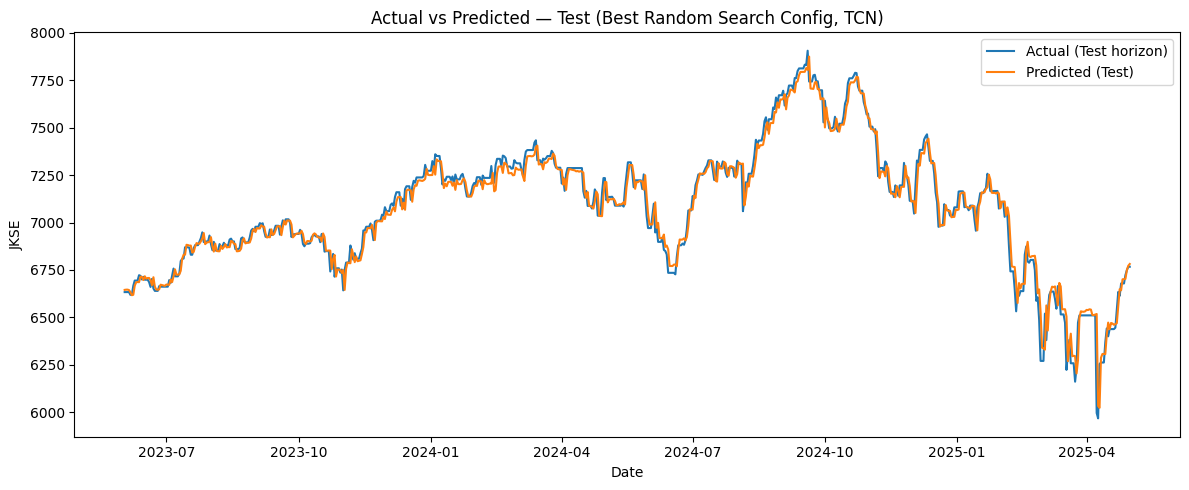

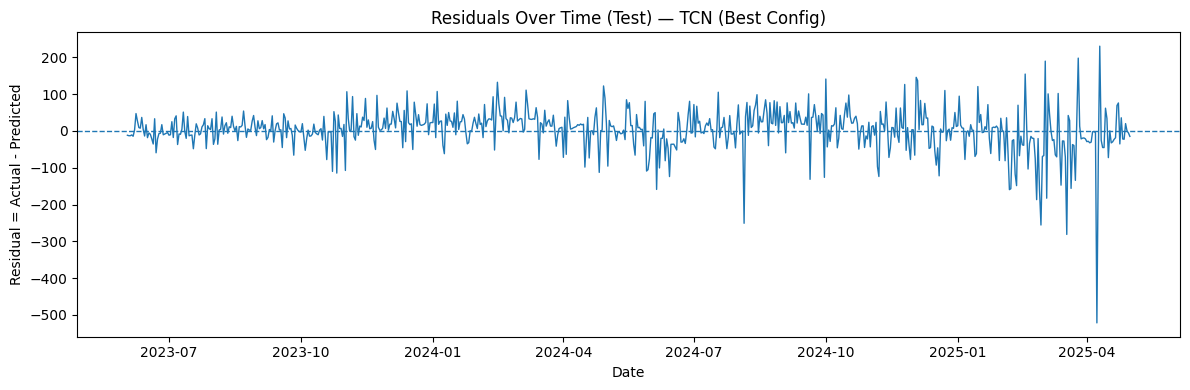

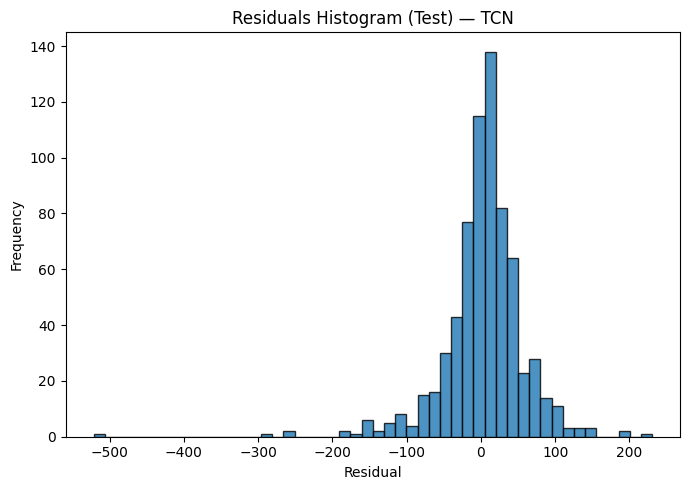

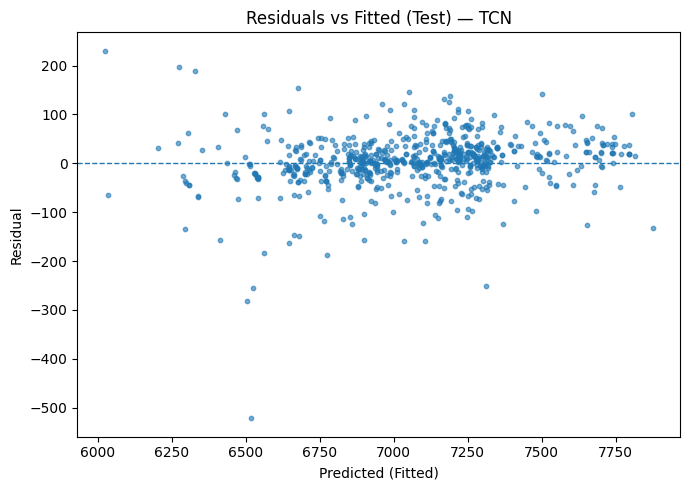

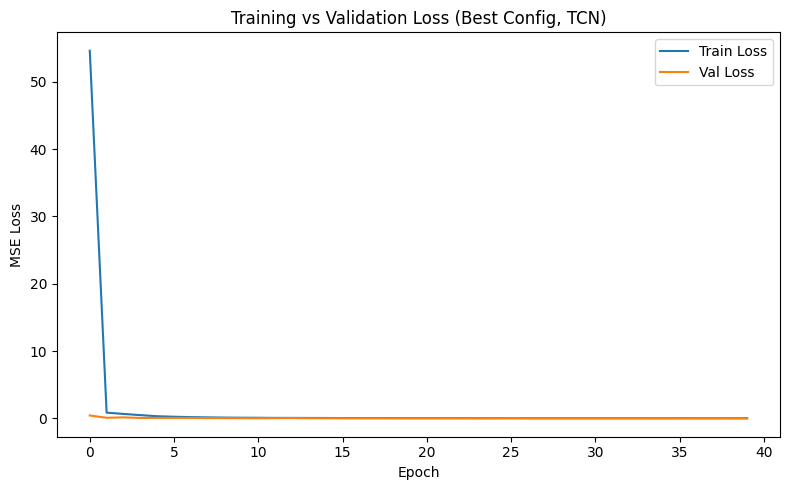

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test.values, label="Actual (Test horizon)", linewidth=1.5)
plt.plot(pred_test.index,   pred_test.values,   label="Predicted (Test)", linewidth=1.5)
plt.title("Actual vs Predicted — Test (Best Random Search Config, TCN)")
plt.xlabel("Date"); plt.ylabel(TARGET_COL)
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 4))
plt.plot(residuals.index, residuals.values, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Test) — TCN (Best Config)")
plt.xlabel("Date"); plt.ylabel("Residual = Actual - Predicted")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7, 5))
plt.hist(residuals.values, bins=50, edgecolor="black", alpha=0.8)
plt.title("Residuals Histogram (Test) — TCN")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7, 5))
plt.scatter(pred_test.values, residuals.values, s=10, alpha=0.6)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals vs Fitted (Test) — TCN")
plt.xlabel("Predicted (Fitted)"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8, 5))
plt.plot(hist_final.history["loss"], label="Train Loss")
plt.plot(hist_final.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss (Best Config, TCN)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.tight_layout(); plt.show()

In [17]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "tcn_rs"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(pred_test.values, index=pd.to_datetime(idx_te), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
# mse, mae, rmse, mape, r2 = metrics_test
picp = mpiw = winkler = 0

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(hpo_end - hpo_start, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")

Model Name for Documentation: tcn_rs_271828183
✅ Predictions saved to ..\Results\ALL_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
